In [1]:
import sys
sys.path.append('/Users/Ziqi/Desktop/mgwr-master')
sys.path.append('/Users/Ziqi/Desktop/spglm')

from mgwr.gwr import GWR,MGWR
from mgwr.sel_bw import Sel_BW
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

### 1. Load the dataset then convert it to Web Mercator projection (epsg=3857)

In [2]:
berlin = gpd.read_file("berlin-listings.geojson").to_crs(epsg=3857)

In [3]:
berlin.columns

Index(['id', 'last_scraped', 'name', 'house_rules', 'host_id', 'host_since',
       'host_is_superhost', 'instant_bookable', 'neighborhood', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'amenities',
       'square_feet', 'price', 'minimum_nights', 'review_scores_rating',
       'geometry'],
      dtype='object')

### 2. Create a random sub-sample of the data with only complete records

In [34]:
subset = berlin[["price","review_scores_rating","accommodates","bathrooms",'bedrooms',"geometry"]]

subset = subset.dropna().sample(1000,random_state=1111)

### 3. Data preparation for MGWR
 - Dependent variable y (N,1)
 - Independent varibales X (N, p)
 - Coordinates of the locations (N, 2)
 - MGWR requires data to be standardised with mean of 0 and std of 1

In [35]:
subset['x'] = subset.geometry.x
subset['y'] = subset.geometry.y

In [36]:
y = subset['price'].values.reshape(-1,1)
X = subset[["review_scores_rating","accommodates","bathrooms",'bedrooms']].values

coords = list(zip(subset['x'],subset['y']))

In [37]:
y = (y - y.mean(axis=0))/y.std(axis=0)
X = (X - X.mean(axis=0))/X.std(axis=0)

### 4. Fitting a GWR model
- Step 1: Select the best bandwidth
- Step 2: Use the bandwidth to fit the model

In [38]:
gwr_selector = Sel_BW(coords,y,X)
gwr_bw = gwr_selector.search()
print("Optimal BW:", gwr_bw)

Optimal BW: 121.0


In [39]:
gwr_rslt = GWR(coords,y,X,gwr_bw).fit()

#### A summary of GWR results

In [40]:
gwr_rslt.summary()

Model type                                                         Gaussian
Number of observations:                                                1000
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            698.781
Log-likelihood:                                                   -1239.729
AIC:                                                               2489.459
AICc:                                                              2491.543
BIC:                                                               2513.998
R2:                                                                   0.301
Adj. R2:                                                              0.298

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### 5. Fitting an MGWR model
- Step 1: Select the best bandwidths
- Step 2: Use the bandwidths to fit the model

In [41]:
mgwr_selector = Sel_BW(coords,y,X,multi=True)
mgwr_bw = mgwr_selector.search()
print("Optimal BWs:",mgwr_bw)

Optimal BWs: [131. 999.  77. 452.  62.]


In [42]:
mgwr_rslt = MGWR(coords,y,X,selector=mgwr_selector).fit()

In [43]:
mgwr_rslt.summary()

Model type                                                         Gaussian
Number of observations:                                                1000
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            698.781
Log-likelihood:                                                   -1239.729
AIC:                                                               2489.459
AICc:                                                              2491.543
BIC:                                                               2513.998
R2:                                                                   0.301
Adj. R2:                                                              0.298

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### 6. Visualise MGWR results

`mgwr_rslt.params` returns the local coefficients (N, p+1)

In [44]:
mgwr_rslt.params

array([[ 0.51086557,  0.04777796,  0.69490177,  0.10815614,  0.23003408],
       [-0.34712447,  0.04504827,  0.3166698 ,  0.15014726,  0.22733303],
       [-0.14959407,  0.04954767,  0.11379177,  0.01743266,  0.52014523],
       ...,
       [-0.33208057,  0.05001557,  0.43663593,  0.01455041,  0.0548579 ],
       [ 0.04793998,  0.04832599,  0.61237566,  0.030755  ,  0.0104264 ],
       [-0.07048664,  0.04813146,  0.37345561,  0.02940989,  0.37342985]])

`mgwr_rslt.filter_tvals()` filters insignificant coefficients (p<0.05, after adjusting for multiple testing) as zeros.

In [45]:
mgwr_rslt.params[mgwr_rslt.filter_tvals() == 0] = np.nan

In [46]:
mgwr_rslt.params

array([[ 0.51086557,         nan,  0.69490177,         nan,         nan],
       [-0.34712447,         nan,         nan,         nan,         nan],
       [        nan,  0.04954767,         nan,         nan,  0.52014523],
       ...,
       [-0.33208057,  0.05001557,         nan,         nan,         nan],
       [        nan,         nan,  0.61237566,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan]])

0

Mapping Local R2

NotImplementedError: Not yet implemented for multiple bandwidths

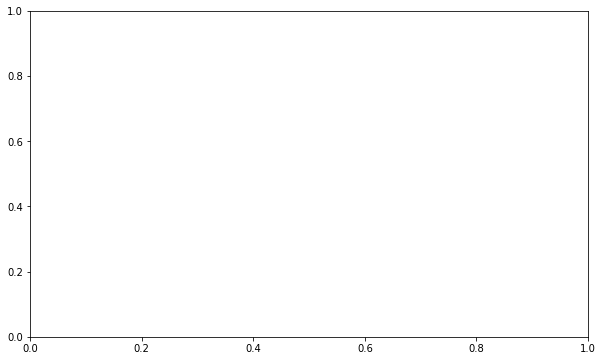

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))
subset.plot(mgwr_rslt.localR2,legend=True,cmap="Reds",ax=ax)

Mapping local coefficients

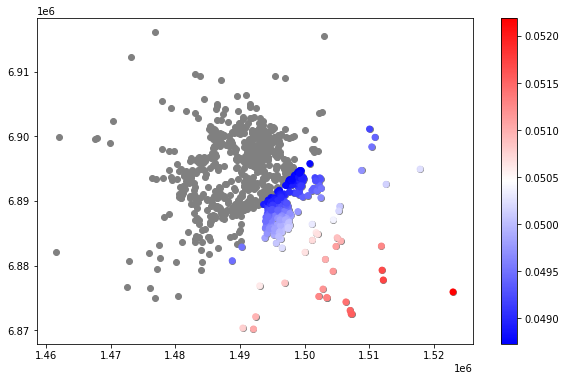

In [47]:
fig, ax = plt.subplots(figsize=(10, 6))
# Use grey to show locations with insignificant coefficients
subset.plot(color='grey',ax=ax)
# Plot significant local coefficients for X1
if np.sum(~np.isnan(mgwr_rslt.params[:,1])) > 0:
    subset.plot(mgwr_rslt.params[:,1],legend=True,cmap="bwr",ax=ax)

<AxesSubplot:>

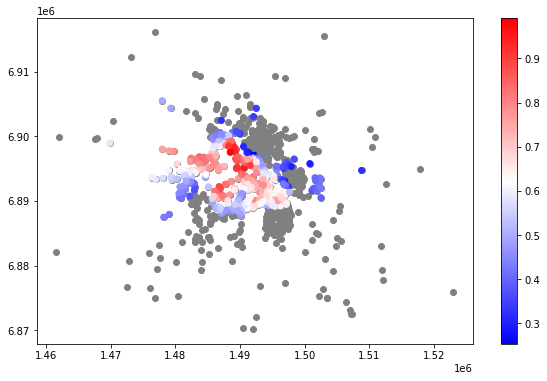

In [48]:
fig, ax = plt.subplots(figsize=(10, 6))
subset.plot(color='grey',ax=ax)
subset.plot(mgwr_rslt.params[:,2],legend=True,cmap="bwr",ax=ax)

<AxesSubplot:>

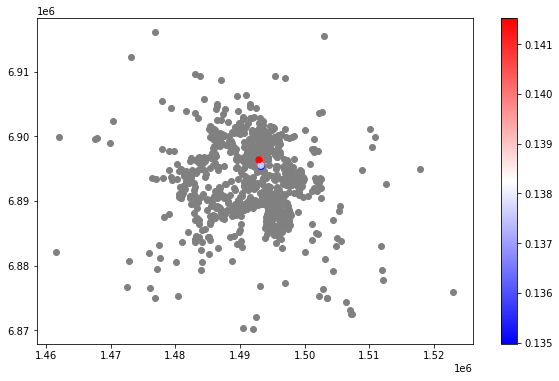

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))
subset.plot(color='grey',ax=ax)
subset.plot(mgwr_rslt.params[:,3],legend=True,cmap="bwr",ax=ax)

<AxesSubplot:>

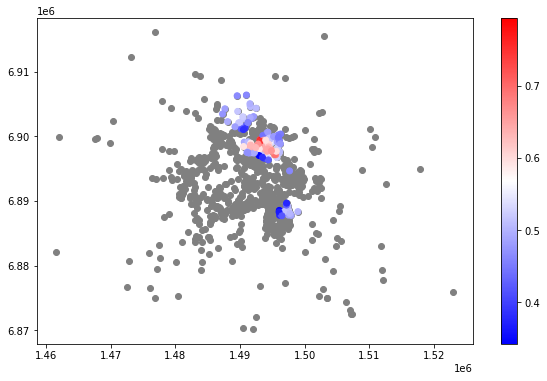

In [50]:
fig, ax = plt.subplots(figsize=(10, 6))
subset.plot(color='grey',ax=ax)
subset.plot(mgwr_rslt.params[:,4],legend=True,cmap="bwr",ax=ax)

Add a basemap tile to provide a bit more context. An alternative option is to add an interactive basemap using `folium`.

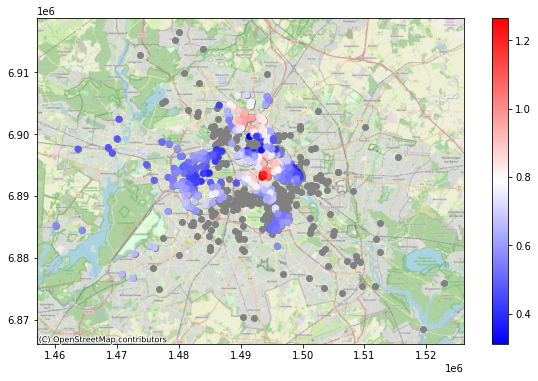

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
subset.plot(color='grey',ax=ax)
subset.plot(mgwr_rslt.params[:,2],legend=True,cmap="bwr",ax=ax)

#Add a basemap using contextuality package
cx.add_basemap(ax,source=cx.providers.OpenStreetMap.Mapnik)